# Interpolatiing Barium on a sphere

* A notebook of my work on interpolation from field obs. to grided data for the model run.

# Content
1. [**Barium Samples**](#Barium-Samples)
  2. [GIPY 2007-11](#GIPY-2007-11)
  2. [BGEP 2003-2005](#BGEP-2003-2005)
1. [**Interpolation**](#Interpolation)
  2. [Vertical profile](#Vertical-profile)
  2. [Horizontal frame](#Horizontal-frame)
  2. [Plot](#Plot)
1. [**Remap on ORCA2 frame**](#Remap-on-ORCA2-frame)
  2. [Plot](#Plot)

In [1]:
import sys
sys.path.insert(0, '_libs/')

In [2]:
import glob
#import pyproj
import scipy.io
import numpy as np
import netCDF4 as nc
import NEMO_tools as Nts
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
% matplotlib inline

In [3]:
from pykrige.ok import OrdinaryKriging
import pykrige.kriging_tools as kt

In [4]:
def find_inland(lon, lat):
    '''
    Identify if data points are located in land
    Based on Basemap's GSHHS dataset
    '''
    from mpl_toolkits.basemap import Basemap
    from matplotlib.path import Path
    result = np.empty(lon.shape)
    proj = Basemap(projection='cyl', resolution='l')
    for i in range(np.size(lon, 0)):
        x, y = proj(lon[i, :], lat[i, :])
        locations = np.c_[x, y]
        polygons = [Path(p.boundary) for p in proj.landpolygons]
        row_result = np.zeros(len(locations), dtype=bool) 
        for polygon in polygons:
            row_result += np.array(polygon.contains_points(locations))
        result[i, :] = row_result
    return result

# Barium Samples

## GIPY 2007-11

* Data is collected from Jul 2007 to Sep 2007
* Only the "good" data points selected
* CTD depth above 15m as "surface"

In [5]:
MAT = scipy.io.loadmat('_data/Samples/GIPY11/GIPY11_Ba.mat')
GIPY_lons = MAT['Ba_records'][:, 0]
GIPY_lats = MAT['Ba_records'][:, 1]
GIPY_deps = MAT['Ba_records'][:, 2]
GIPY_Ba   = MAT['Ba_records'][:, 3]

## BGEP 2003-2005

* http://www.whoi.edu/page.do?pid=66521
* Data collected at the summer of 2003, 2004, 2005
* Only "Good" data points selected
* CTD depth above 15m as "surface"

In [6]:
MAT = scipy.io.loadmat('_data/Samples/BGEP/BGEP_Ba.mat')
x03 = MAT['Ba2003'][:, 1]; y03 = MAT['Ba2003'][:, 0]; z03 = MAT['Ba2003'][:, 2]; Ba03 = MAT['Ba2003'][:, 3]
x04 = MAT['Ba2004'][:, 1]; y04 = MAT['Ba2004'][:, 0]; z04 = MAT['Ba2004'][:, 2]; Ba04 = MAT['Ba2004'][:, 3]
x04[Ba04<0]=np.nan; y04[Ba04<0]=np.nan; z04[Ba04<0]=np.nan; Ba04[Ba04<0]=np.nan
x05 = MAT['Ba2005'][:, 1]; y05 = MAT['Ba2005'][:, 0]; z05 = MAT['Ba2005'][:, 2]; Ba05 = MAT['Ba2005'][:, 3]

#Interpolation

## Vertical profile

In [7]:
GIPY_locs = np.unique(GIPY_lons)
loc03 = np.unique(x03)
loc04 = np.unique(x04)
loc05 = np.unique(x05)

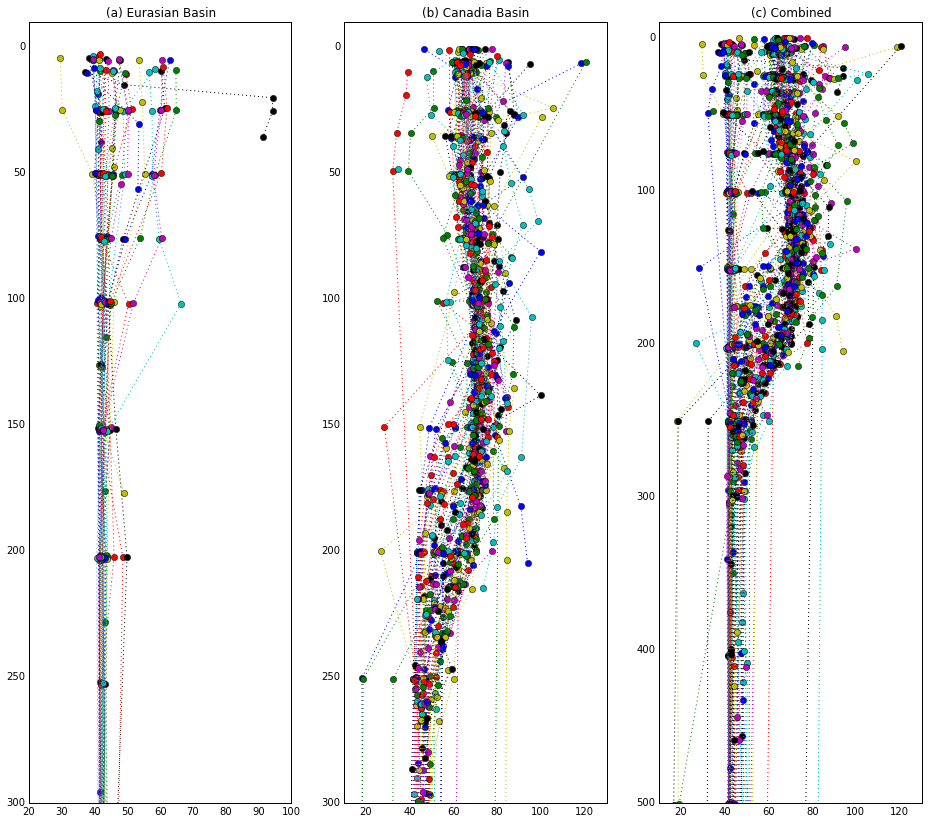

In [12]:
fig = plt.figure(figsize=(16, 14)); 
ax1 = plt.subplot(1, 3, 1)
ax1.set_ylim(-10, 300); ax1.set_xlim(20, 100)
ax1.invert_yaxis()
ax1.xaxis.set_tick_params(size=0)
ax1.yaxis.set_tick_params(size=0)
for i in range(len(GIPY_locs)):
    ax1.plot(GIPY_Ba[GIPY_lons==GIPY_locs[i]], GIPY_deps[GIPY_lons==GIPY_locs[i]], 'o:')
ax1.set_title('(a) Eurasian Basin', fontsize=12)
    
ax2 = plt.subplot(1, 3, 2)
ax2.set_ylim(-10, 300); ax2.set_xlim(10, 130)
ax2.invert_yaxis()
ax2.xaxis.set_tick_params(size=0)
ax2.yaxis.set_tick_params(size=0)
for i in range(len(loc03)):
    ax2.plot(Ba03[x03 == loc03[i]], z03[x03 == loc03[i]], 'o:')
for i in range(len(loc04)):
    ax2.plot(Ba04[x04 == loc04[i]], z04[x04 == loc04[i]], 'o:')
for i in range(len(loc05)):
    ax2.plot(Ba05[x05 == loc05[i]], z05[x05 == loc05[i]], 'o:')
ax2.set_title('(b) Canadia Basin', fontsize=12)

ax3 = plt.subplot(1, 3, 3)
ax3.set_ylim(-10, 500); ax3.set_xlim(10, 130)
ax3.invert_yaxis()
ax3.xaxis.set_tick_params(size=0)
ax3.yaxis.set_tick_params(size=0)
for i in range(len(GIPY_locs)):
    ax3.plot(GIPY_Ba[GIPY_lons==GIPY_locs[i]], GIPY_deps[GIPY_lons==GIPY_locs[i]], 'o:')
for i in range(len(loc03)):
    ax3.plot(Ba03[x03 == loc03[i]], z03[x03 == loc03[i]], 'o:')
for i in range(len(loc04)):
    ax3.plot(Ba04[x04 == loc04[i]], z04[x04 == loc04[i]], 'o:')
for i in range(len(loc05)):
    ax3.plot(Ba05[x05 == loc05[i]], z05[x05 == loc05[i]], 'o:')
ax3.set_title('(c) Combined', fontsize=12)

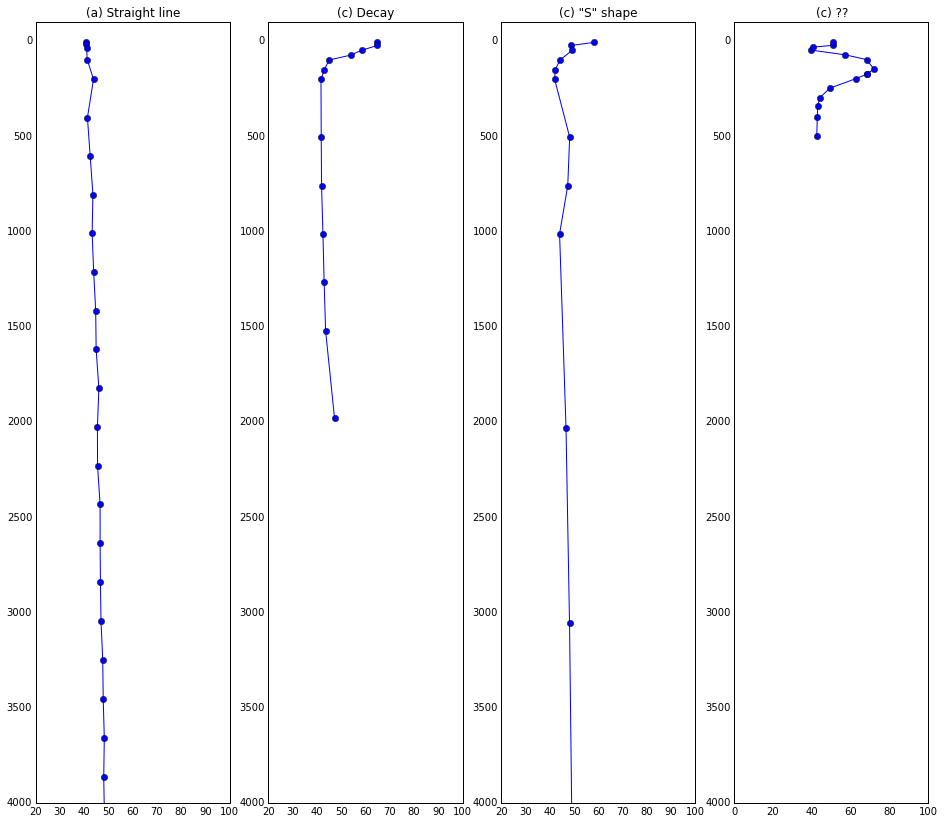

In [42]:
fig = plt.figure(figsize=(16, 14)); 
ax1 = plt.subplot(1, 4, 1)
i=3; ax1.plot(GIPY_Ba[GIPY_lons==GIPY_locs[i]], GIPY_deps[GIPY_lons==GIPY_locs[i]], 'o-')
ax1.set_ylim(-100, 4000); ax1.set_xlim(20, 100); ax1.invert_yaxis()
ax1.xaxis.set_tick_params(size=0); ax1.yaxis.set_tick_params(size=0)
ax1.set_title('(a) Straight line', fontsize=12)

ax2 = plt.subplot(1, 4, 2)
i=36; ax2.plot(GIPY_Ba[GIPY_lons==GIPY_locs[i]], GIPY_deps[GIPY_lons==GIPY_locs[i]], 'o-')
ax2.set_ylim(-100, 4000); ax2.set_xlim(20, 100); ax2.invert_yaxis()
ax2.xaxis.set_tick_params(size=0); ax2.yaxis.set_tick_params(size=0)
ax2.set_title('(c) Decay', fontsize=12)

ax3 = plt.subplot(1, 4, 3)
i=24; ax3.plot(GIPY_Ba[GIPY_lons==GIPY_locs[i]], GIPY_deps[GIPY_lons==GIPY_locs[i]], 'o-')
ax3.set_ylim(-100, 4000); ax3.set_xlim(20, 100); ax3.invert_yaxis()
ax3.xaxis.set_tick_params(size=0); ax3.yaxis.set_tick_params(size=0)
ax3.set_title('(c) "S" shape', fontsize=12)

ax4 = plt.subplot(1, 4, 4)
i=15; ax4.plot(Ba03[x03 == loc03[i]], z03[x03 == loc03[i]], 'o-')
ax4.set_ylim(-100, 4000); ax4.set_xlim(0, 100); ax4.invert_yaxis()
ax4.xaxis.set_tick_params(size=0); ax4.yaxis.set_tick_params(size=0)
ax4.set_title('(c) ??', fontsize=12)

## Horizontal frame

**GIPY**

In [19]:
hit = deps < 15
lon_surf = GIPY_lons[hit]; lat_surf = GIPY_lats[hit]; Ba_surf  = GIPY_Ba[hit]
_, indices = np.unique(lon_surf, return_index=True)
GIPY_x = lon_surf[indices]; GIPY_y = lat_surf[indices]; GIPY_z = Ba_surf[indices]
#
GIPY_x[GIPY_x>180]=GIPY_x[GIPY_x>180]-360

**BGEP**

In [20]:
hit = z03 < 15
lon_surf = x03[hit]; lat_surf = y03[hit]; Ba_surf  = Ba03[hit]
_, indices = np.unique(lon_surf, return_index=True)
BGEP03_x = lon_surf[indices]; BGEP03_y = lat_surf[indices]; BGEP03_z = Ba_surf[indices]

In [21]:
hit = z04 < 15
lon_surf = x04[hit]; lat_surf = y04[hit]; Ba_surf  = Ba04[hit]
_, indices = np.unique(lon_surf, return_index=True)
BGEP04_x = lon_surf[indices]; BGEP04_y = lat_surf[indices]; BGEP04_z = Ba_surf[indices]

In [22]:
hit = z05 < 15
lon_surf = x05[hit]; lat_surf = y05[hit]; Ba_surf  = Ba05[hit]
_, indices = np.unique(lon_surf, return_index=True)
BGEP05_x = lon_surf[indices]; BGEP05_y = lat_surf[indices]; BGEP05_z = Ba_surf[indices]

**Combine samples**

In [23]:
x = np.hstack((GIPY_x, BGEP03_x, BGEP04_x, BGEP05_x))
y = np.hstack((GIPY_y, BGEP03_y, BGEP04_y, BGEP05_y))
z = np.hstack((GIPY_z, BGEP03_z, BGEP04_z, BGEP05_z))

### Projection transformation

<img src="_figures/Projxy.PNG" width=450 align="left"/>

*The reference surface with geographic coordinates $\mathsf{(\phi,\lambda)}$ is projected onto a 2D Cartesian plane $\mathsf{(x, y)}$.*

In [24]:
#p1 = pyproj.Proj('+proj=stere')
p1=Basemap(projection='npstere', resolution='l', boundinglat=0, lon_0=90, ax=ax)
# reproj x, y
x_trans, y_trans = p1(x, y)
# create frame
listx_trans = np.linspace(x_trans.min(), x_trans.max(), 100)
listy_trans = np.linspace(y_trans.min(), y_trans.max(), 100)
gridx_trans, gridy_trans = np.meshgrid(listx_trans, listy_trans)
# convert frame back to lat/lon
listx, listy = p1(listx_trans, listy_trans, inverse=True)
gridx, gridy = p1(gridx_trans, gridy_trans, inverse=True)

In [25]:
GIPYx_trans, GIPYy_trans = p1(GIPY_x, GIPY_y)
BGEP03x_trans, BGEP03y_trans = p1(BGEP03_x, BGEP03_y)
BGEP04x_trans, BGEP04y_trans = p1(BGEP04_x, BGEP04_y)
BGEP05x_trans, BGEP05y_trans = p1(BGEP05_x, BGEP05_y)

### Kriging

In [26]:
#OK = OrdinaryKriging(x_trans, y_trans, z, variogram_model='linear', verbose=False, enable_plotting=False)
#Ba_int, ss = OK.execute('grid', listx_trans, listy_trans)
MAT = scipy.io.loadmat('_data/Exchange/Temp_Ba_int.mat')
Ba_int = MAT['Ba_int'][:]

In [27]:
## Save
#save_var = { 'Ba_int': Ba_int, 'lon': gridx, 'lat': gridy}#, 'lon_trans':gridx_trans, 'lat_trans':gridy_trans  }
#scipy.io.savemat('_data/Exchange/Temp_Ba_int.mat', mdict=save_var)

## Plot

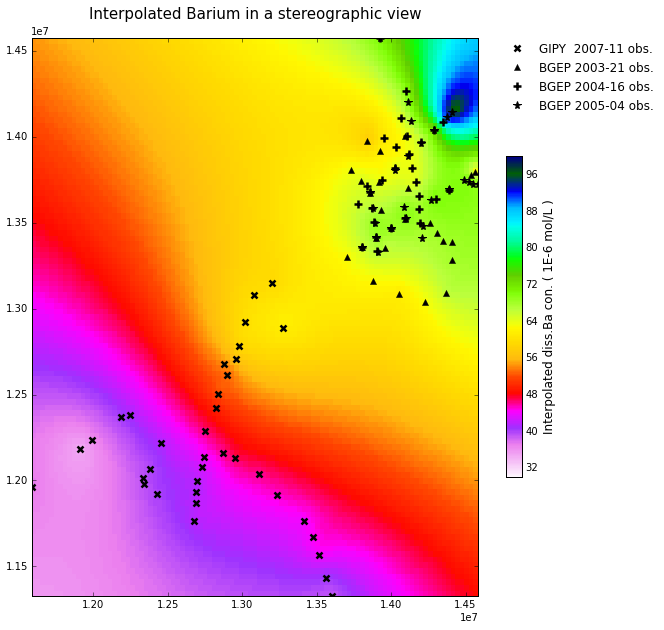

In [28]:
fig=plt.figure(figsize=(10, 10))
ax=fig.gca()
ax.set_xlim(x_trans.min(), x_trans.max())
ax.set_ylim(y_trans.min(), y_trans.max())
CS = ax.pcolor(gridx_trans, gridy_trans, Ba_int, vmin=30, vmax=100, cmap=plt.cm.gist_ncar_r)
ax.plot(  GIPYx_trans,  GIPYy_trans, 'kx', ms=6, mew=2.5, label='GIPY  2007-11 obs.')
ax.plot(BGEP03x_trans, BGEP03y_trans, 'k^', ms=6, mew=0.5, label='BGEP 2003-21 obs.')
ax.plot(BGEP04x_trans, BGEP04y_trans, 'k+', ms=8, mew=2.5, label='BGEP 2004-16 obs.')
ax.plot(BGEP05x_trans, BGEP05y_trans, 'k*', ms=8, mew=1.0, label='BGEP 2005-04 obs.')
CBar = plt.colorbar(CS, shrink=0.575)
CBar.set_label('Interpolated diss.Ba con. ( 1E-6 mol/L )', fontsize=12)
CBar.ax.tick_params(axis='y', length=0)
LG = ax.legend(numpoints=1, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.); LG.draw_frame(False)
ax.set_title('Interpolated Barium in a stereographic view', fontsize=15, y=1.025)

# Remap on ORCA2 frame

In [29]:
coordinate_name=glob.glob('_data/NEMO/ORCA2_INPUT/coordinates*.nc')
coordinate_obj=nc.Dataset(coordinate_name[0])
nav_lon=coordinate_obj.variables['nav_lon'][:]
nav_lat=coordinate_obj.variables['nav_lat'][:]

In [30]:
Ba_ini_orca = Nts.reporj_NEMOgrid(gridx, gridy, Ba_int, nav_lon, nav_lat, method='linear')

In [31]:
hit = find_inland(nav_lon, nav_lat); Ba_ini_orca[hit==1]=np.nan
Ba_ini_masked = np.ma.masked_where(np.isnan(Ba_ini_orca), Ba_ini_orca)

## Plot

In [32]:
ETOPO2_Arctic=scipy.io.loadmat('_libs/ETOPO2_Arctic.mat')
lon_arctic=ETOPO2_Arctic['lon_arctic']
lat_arctic=ETOPO2_Arctic['lat_arctic']
topo_arctic=ETOPO2_Arctic['topo_arctic']

In [33]:
# Adjust resolution
res_unit=5
lon_arctic=lon_arctic[0:-1:res_unit, 0:-1:res_unit]
lat_arctic=lat_arctic[0:-1:res_unit, 0:-1:res_unit]
topo_arctic=topo_arctic[0:-1:res_unit, 0:-1:res_unit]*-1

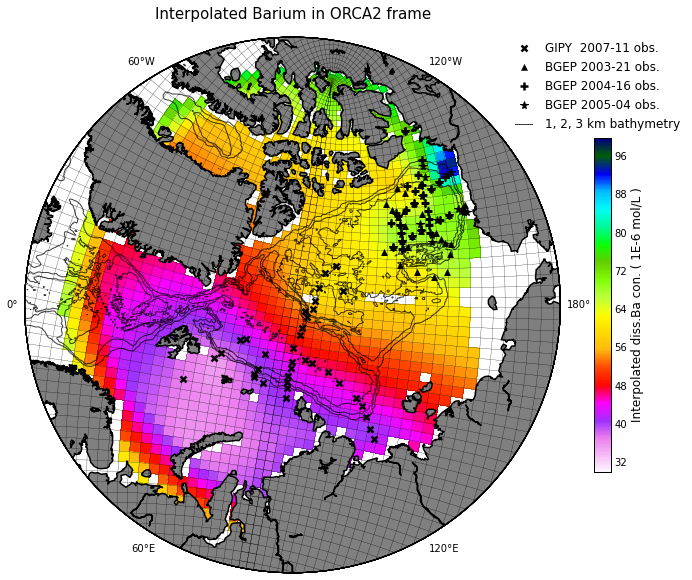

In [34]:
clevs=[1000, 2000, 3000]
fig=plt.figure(figsize=(12, 12)); ax=plt.gca()
proj=Basemap(projection='npstere', resolution='l', boundinglat=65, lon_0=90, round=True, ax=ax)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
proj.drawcoastlines(linewidth=1.5, color='k')
gridx, gridy = proj(nav_lon, nav_lat)
GIPYx_trans, GIPYy_trans = proj(GIPY_x, GIPY_y)
BGEP03x_trans, BGEP03y_trans = proj(BGEP03_x, BGEP03_y)
BGEP04x_trans, BGEP04y_trans = proj(BGEP04_x, BGEP04_y)
BGEP05x_trans, BGEP05y_trans = proj(BGEP05_x, BGEP05_y)
topox, topoy = proj(lon_arctic, lat_arctic)
CS = proj.pcolor(gridx, gridy, Ba_ini_masked, vmin=30, vmax=100, cmap=plt.cm.gist_ncar_r)
CS2 = proj.contour(topox, topoy, topo_arctic, clevs, linestyles='-', linewidths=1, colors=('k',), alpha=0.75)
CS2.collections[0].set_label('1, 2, 3 km bathymetry')
proj.plot(  GIPYx_trans, GIPYy_trans, 'kx', ms=6, mew=2.5, label='GIPY  2007-11 obs.')
proj.plot(BGEP03x_trans, BGEP03y_trans, 'k^', ms=6, mew=0.5, label='BGEP 2003-21 obs.')
proj.plot(BGEP04x_trans, BGEP04y_trans, 'k+', ms=8, mew=2.5, label='BGEP 2004-16 obs.')
proj.plot(BGEP05x_trans, BGEP05y_trans, 'k*', ms=8, mew=1.0, label='BGEP 2005-04 obs.')
proj.plot(gridx.T, gridy.T, 'k-', lw=0.25)
proj.plot(gridx, gridy, 'k-', lw=0.25)
CBar = plt.colorbar(CS, shrink=0.5)
CBar.set_label('Interpolated diss.Ba con. ( 1E-6 mol/L )', fontsize=12)
CBar.ax.tick_params(axis='y', length=0)
LG = ax.legend(numpoints=1, bbox_to_anchor=(0.9, 1), loc=2, borderaxespad=0.); LG.draw_frame(False)
ax.set_title('Interpolated Barium in ORCA2 frame', fontsize=15, y=1.025)
#fig.savefig('Publish/Barium_4.pdf', dpi=600, orientation='portrait', papertype='a4', format='pdf',
#            transparent=False, bbox_inches='tight', pad_inches=0)

**Compare with Guay (1997)'s work'**

<img src="_figures/Gauy_Ba_map.PNG" width=650 align="left"/>